## Описание проекта

Проект "Определение стоимости автомобилей"

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны качество предсказания и время обучения.

## Подготовка данных

In [1]:
# Загрузим необходимые библиотеки
!pip install shap -q
!pip install scikit-learn==1.1.3 -q
!pip -q install phik
!pip install category_encoders

In [2]:
# Импортируем необходимые нам библиотеки
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from scipy.stats import binom, norm, spearmanr
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import time
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import shap

# снимим ограничение на ширину столбцов
pd.set_option('display.max_colwidth', None)

### Загрузка данных

In [3]:
# Загрузим данные /datasets/autos.csv. 
# Ознакомимся с содержимым.
data = pd.read_csv('/datasets/autos.csv')
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


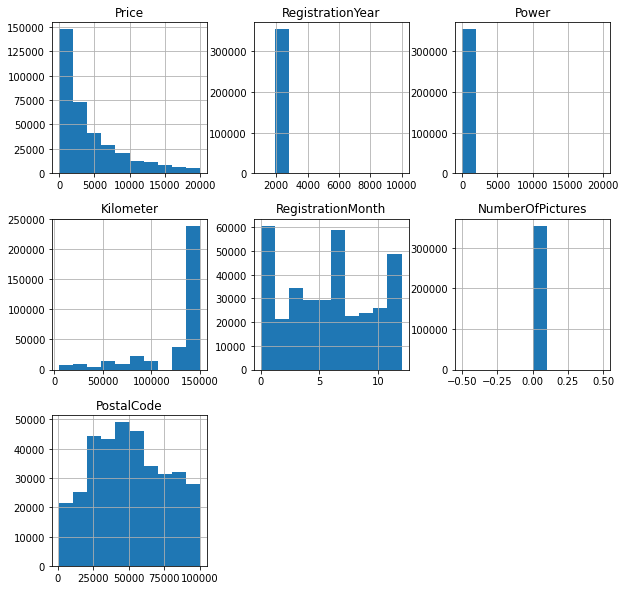

In [4]:
# Посмотрим на распределения числовых признаков в датасете
data.hist(figsize=(10, 10))
data.describe()

In [5]:
# Закончим ознакомление с данными выводом доли пропущенных значений по каждому признаку
nan_ratio_per_column = (data.isnull().sum() / len(data)) * 100
print(nan_ratio_per_column.map("{:.2f}%".format))

DateCrawled           0.00%
Price                 0.00%
VehicleType          10.58%
RegistrationYear      0.00%
Gearbox               5.60%
Power                 0.00%
Model                 5.56%
Kilometer             0.00%
RegistrationMonth     0.00%
FuelType              9.28%
Brand                 0.00%
Repaired             20.08%
DateCreated           0.00%
NumberOfPictures      0.00%
PostalCode            0.00%
LastSeen              0.00%
dtype: object


Вывод по загрузке и ознакомлению с данными:

Данные загрузились корректно. Датасет содержит более 350 тысяч строк и 16 столбцов. 
Имеется значительное количество пропусков в признаках 'VehicleType', 'Gearbox', 'Power', 'Model', 'FuelType' и 'Repaired' которые необходимо будет восполнять. Также есть явные выбросы в признаках 'RegistrationYear' и 'Power', а в столбце 'NumberOfPictures' только нулевые значения.
Исправим выявленные недостатки в данных на этапе предобработки.

### Предобработка данных

In [6]:
# Создадим функцию вывода круговой диаграммы для категориальных данных
def pie_cat (df, col, title, label):
    group_tab = df.groupby(col).size()/len(df)
    group_tab = group_tab.sort_values(ascending=True)
    group_tab.plot(kind='pie', autopct = '%1.0f%%', normalize=False)
    plt.title(f'{title}')
    plt.ylabel(f'{label}')
    plt.show() 

In [7]:
# Создадим функцию вывода гистограммы распределения для числовых данных
def hist_num (df, col, title, label, bins):
    plt.figure(figsize=(10, 6))
    df[col].plot(kind = 'hist', grid=True, bins=bins)
    plt.title(f'{title}')
    plt.ylabel('Частота')
    plt.xlabel(f'{label}')
    plt.show()
    display(df[col].describe())

Предобработку данных начнем с целевого признака признака 'Price'.

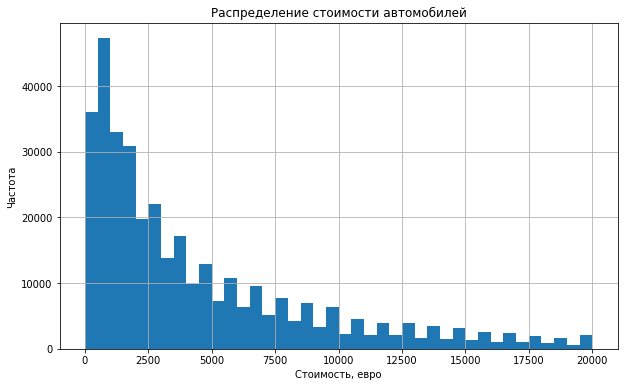

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

In [8]:
# Выведем диаграмму распределения стоимости автомобилей 
df=data
col='Price'
title='Распределение стоимости автомобилей'
label='Стоимость, евро'
bins=40
hist_num(df, col, title, label, bins)

В данных есть объявления где стоимость равна нулю либо чуть больше, это явно некорректная стоимость. Нам необходимо их отсечь минимальной корректной стоимостью автомобиля. Для этого выведем гистограмму по стоимости для автомобилей до 500 евро. 

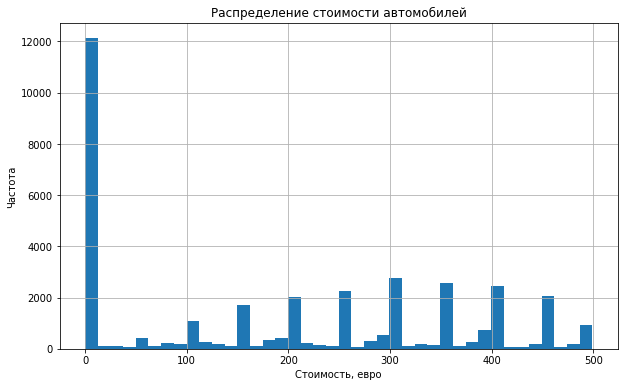

count    36054.000000
mean       192.706357
std        168.061252
min          0.000000
25%          0.000000
50%        200.000000
75%        350.000000
max        499.000000
Name: Price, dtype: float64

In [9]:
# Выведем диаграмму распределения стоимости автомобилей до 500 евро
df=data[data['Price'] < 500]
col='Price'
title='Распределение стоимости автомобилей'
label='Стоимость, евро'
bins=40
hist_num(df, col, title, label, bins)

Минимальную корректную стоимость зафиксируем на уровне  40 евро

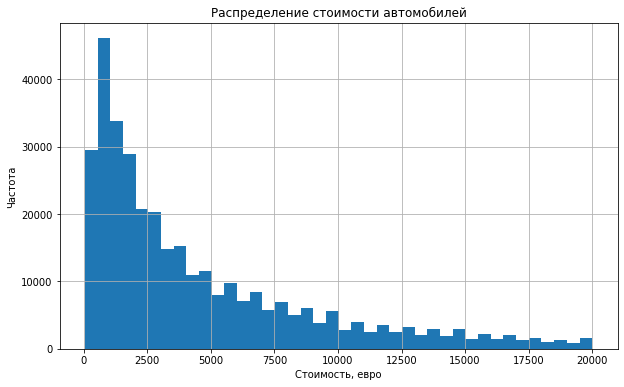

count    341975.000000
mean       4576.698607
std        4514.844784
min          45.000000
25%        1200.000000
50%        2900.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

In [10]:
# Удалим строки с ценой менее 40 евро
data = data[data['Price'] > 40]
# И выведем итоговую диаграмму распределения стоимости автомобилей
df=data
col='Price'
title='Распределение стоимости автомобилей'
label='Стоимость, евро'
bins=40
hist_num(df, col, title, label, bins)

Распределение корректное. С целевым признаком разобрались. 
<br>
Далее необходимо продумать очередность работ по заполнению пропусков корректными данными.

In [11]:
# Еще раз взглянем на доли пропущенных значений по каждому признаку
nan_ratio_per_column = (data.isnull().sum() / len(data)) * 100
print(nan_ratio_per_column.map("{:.2f}%".format))

DateCrawled           0.00%
Price                 0.00%
VehicleType           9.65%
RegistrationYear      0.00%
Gearbox               4.88%
Power                 0.00%
Model                 5.02%
Kilometer             0.00%
RegistrationMonth     0.00%
FuelType              8.40%
Brand                 0.00%
Repaired             18.97%
DateCreated           0.00%
NumberOfPictures      0.00%
PostalCode            0.00%
LastSeen              0.00%
dtype: object


Пропуски в данных 'VehicleType', 'Gearbox' и 'FuelType', а также некорректные значения в других столбцах мы будем заполнять средними или модальными значениями для соответствующих комбинаций 'Brand' и/или 'Model'. И если в столбце 'Brand' пропусков нет, то в столбце 'Model' их 5%, а возможности заполнить их корректно мы не имеем. Поэтому, для начала нам следует удалить строки с пропусками в 'Model'.

In [12]:
# Выведем количество таких строк
data['Model'].isna().sum()

17169

In [13]:
# Удалим строки с пропусками в 'Model'
data = data.dropna(subset=['Model'])
# Проверим результат
print(data['Model'].isna().sum())

0


Проверим данные 'Model' на наличие опечаток

In [14]:
df_model = pd.DataFrame(data.groupby('Brand')['Model'].unique())
df_model

,Model
Brand,
alfa_romeo,"[156, 147, spider, 159, other, 145]"
audi,"[a8, a4, a1, tt, a6, 80, 100, a3, a2, a5, other, 90, q7, q3, 200, q5]"
bmw,"[3er, 5er, 1er, 7er, z_reihe, 6er, other, x_reihe, m_reihe, i3]"
chevrolet,"[other, matiz, spark, captiva, aveo]"
chrysler,"[other, ptcruiser, crossfire, 300c, grand, voyager]"
citroen,"[c4, berlingo, c1, other, c3, c5, c2]"
dacia,"[logan, duster, sandero, lodgy, other]"
daewoo,"[lanos, kalos, matiz, other, nubira]"
daihatsu,"[cuore, sirion, other, charade, move, terios, materia]"


В целом бренды и их модели указаны корректно и не видно явных дублирований за исключением строк с брендами land_rover и rover. Это явно один и тот же производитель со схожим модельным рядом. Т.к. в land_rover ряд более полный мы присоединим к нему данные бренда rover.  

In [15]:
# Исправим выявленые дублирования в данных 
data['Brand'] = data['Brand'].replace('rover', 'land_rover')
data['Model'] = data['Model'].replace('rangerover', 'range_rover')

/tmp/ipykernel_172/122252977.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Brand'] = data['Brand'].replace('rover', 'land_rover')
/tmp/ipykernel_172/122252977.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Model'] = data['Model'].replace('rangerover', 'range_rover')


In [16]:
# Проверим результат
df_model = pd.DataFrame(data.groupby('Brand')['Model'].unique())
df_model

,Model
Brand,
alfa_romeo,"[156, 147, spider, 159, other, 145]"
audi,"[a8, a4, a1, tt, a6, 80, 100, a3, a2, a5, other, 90, q7, q3, 200, q5]"
bmw,"[3er, 5er, 1er, 7er, z_reihe, 6er, other, x_reihe, m_reihe, i3]"
chevrolet,"[other, matiz, spark, captiva, aveo]"
chrysler,"[other, ptcruiser, crossfire, 300c, grand, voyager]"
citroen,"[c4, berlingo, c1, other, c3, c5, c2]"
dacia,"[logan, duster, sandero, lodgy, other]"
daewoo,"[lanos, kalos, matiz, other, nubira]"
daihatsu,"[cuore, sirion, other, charade, move, terios, materia]"


Строки rover исчезли, длина списка land_rover не изменилась. С 'Model' разобрались

Далее продолжим с предобработкой количественных признаков. Начнем с 'Power'.

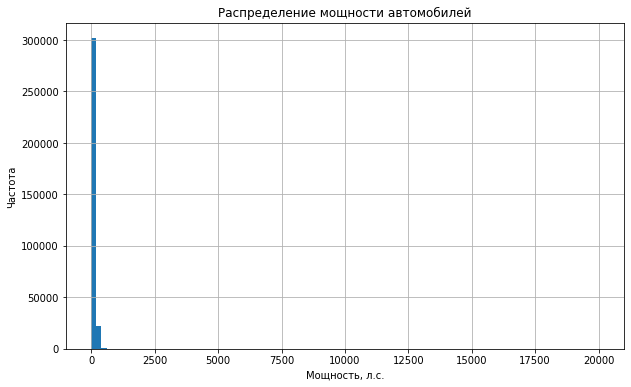

count    324806.000000
mean        112.128049
std         182.986461
min           0.000000
25%          72.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

In [17]:
# Выведем диаграмму распределения мощности автомобилей
df=data
col='Power'
title='Распределение мощности автомобилей'
label='Мощность, л.с.'
bins=100
hist_num(df, col, title, label, bins)

Есть явные выбросы в значениях мощности до 20000 л.с., также есть автомобили с нулевой мощностью. Так как мы создаем приложение определяющее рыночную стоимость автомобилей, мы удалим строки с мощностью более 500 л.с. так как продажи таких авто единичны, а само понятие "рыночной стоимости" для них очень условно.

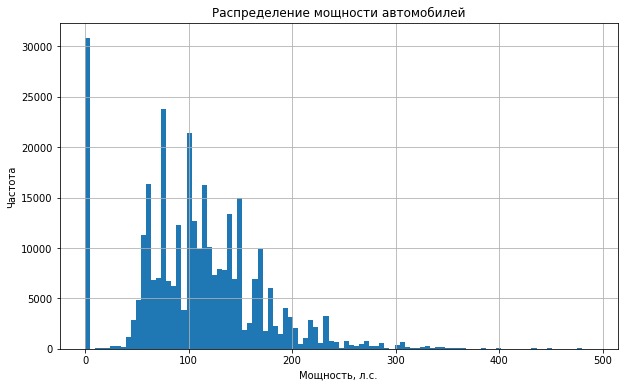

count    324401.000000
mean        108.727202
std          61.390483
min           0.000000
25%          72.000000
50%         105.000000
75%         143.000000
max         490.000000
Name: Power, dtype: float64

In [18]:
# Удалим строки с мощностью более 500 л.с.
data = data[data['Power'] < 500]

# Выведем диаграмму распределения мощности автомобилей
df=data
col='Power'
title='Распределение мощности автомобилей'
label='Мощность, л.с.'
bins=100
hist_num(df, col, title, label, bins)

Количество строк с нулевой мощностью существенное, более 10% датасета. Заполним их средним значением для соответствующих брендов и их моделей. Но перед этим определим минимальную корректную мощность автомобилей.

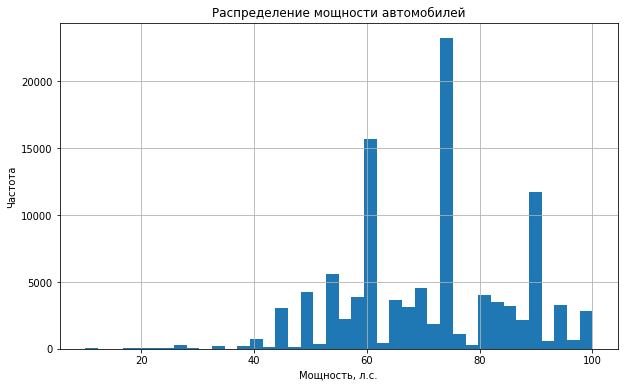

count    107129.000000
mean         71.246600
std          14.710867
min          10.000000
25%          60.000000
50%          75.000000
75%          82.000000
max         100.000000
Name: Power, dtype: float64

In [19]:
# Выведем диаграмму распределения мощности автомобилей до 100 л.с.
df=data.query('10 <= Power <= 100')
col='Power'
title='Распределение мощности автомобилей'
label='Мощность, л.с.'
bins=40
hist_num(df, col, title, label, bins)

Минимальную корректную мощность автомобилей определим на уровне 40 л.с., все что меньше  заменим на NaN, а затем заполним средним значением для данных брендов и моделей. 

In [20]:
# Заменим некорректные значения мощности на NaN
data['Power'] = data['Power'].apply(lambda x: np.nan if x < 40 else x)
# Выведем количество получившихся строк с NaN в 'Power'
print(data['Power'].isna().sum())

31816


In [21]:
# Заполним пропуски в столбце 'Power' средним значением для каждого производителя и модели
data['Power'] = data['Power'].fillna(data.groupby(['Brand', 'Model'])['Power'].transform('mean'))

# Проверим результат
print(data['Power'].isna().sum())

1


Осталось одна строка с NaN в столбце 'Power'. Выведем ее.

In [22]:
data.query('Power.isnull()')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
234296,2016-03-30 11:39:08,3800,wagon,1978,manual,NaN,serie_1,30000,0,gasoline,land_rover,NaN,2016-03-30 00:00:00,0,49824,2016-03-30 11:39:08


Вероятно, бренд или модель указаны неверно, либо модель редкая и для нее нет данных для вычисления среднего значения.
Удалим ее, ценность этой строки нулевая.

In [23]:
data = data.dropna(subset=['Power'])

Посмотрим на итоговое распределение.

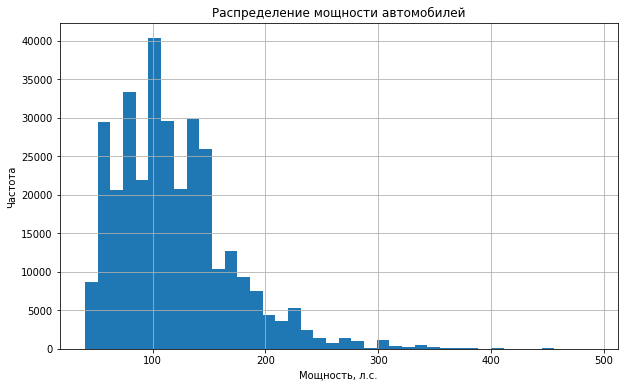

count    324400.000000
mean        119.450207
std          51.724024
min          40.000000
25%          75.000000
50%         110.000000
75%         147.000000
max         490.000000
Name: Power, dtype: float64

In [24]:
# Выведем диаграмму распределения мощности автомобилей
df=data
col='Power'
title='Распределение мощности автомобилей'
label='Мощность, л.с.'
bins=40
hist_num(df, col, title, label, bins)

Далее осуществим предобработку данных 'RegistrationYear'

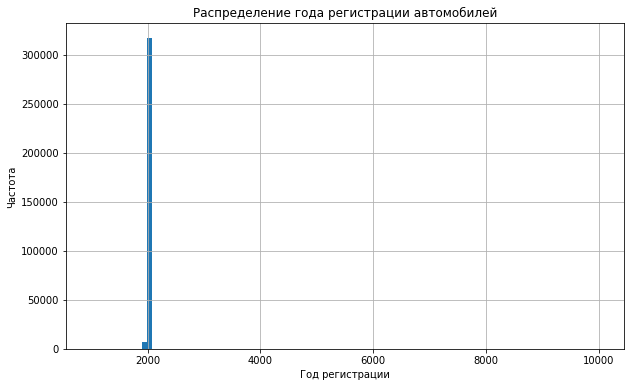

count    324400.000000
mean       2003.926782
std          65.038584
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

In [25]:
# Выведем диаграмму распределения года регистрации автомобилей
df=data
col='RegistrationYear'
title='Распределение года регистрации автомобилей'
label='Год регистрации'
bins=100
hist_num(df, col, title, label, bins)

Данные явно содержат явные опечатки и выбросы, ограничим выводимое распределение 1930 - 2030 годами

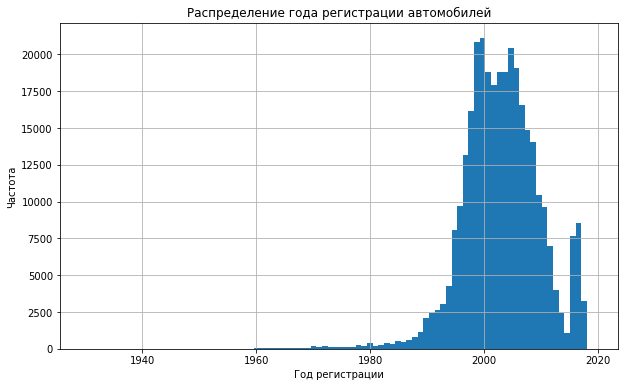

count    324302.000000
mean       2003.289514
std           6.986929
min        1930.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        2019.000000
Name: RegistrationYear, dtype: float64

In [26]:
# Выведем диаграмму распределения года регистрации автомобилей 
df=data.query('1930 <= RegistrationYear <= 2030')
col='RegistrationYear'
title='Распределение года регистрации автомобилей'
label='Год регистрации'
bins=90
hist_num(df, col, title, label, bins)

Полагаю, мы можем удалить строки с годами регистрации автомобилей до 1960. Для определения верхней границы корректного года регистрации мы воспользуемся данными по выгрузке анкет из базы. Очевидно, что год регистрации не может быть позже этих дат.

In [27]:
data.sort_values(by='DateCrawled').tail(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
204218,2016-04-07 14:36:53,6990,coupe,1979,auto,143.0,3er,150000,6,petrol,bmw,no,2016-04-07 00:00:00,0,71336,2016-04-07 14:36:53
53739,2016-04-07 14:36:54,400,small,1996,manual,60.0,ibiza,150000,0,NaN,seat,NaN,2016-04-07 00:00:00,0,66299,2016-04-07 14:36:54
301030,2016-04-07 14:36:55,15200,wagon,2008,manual,190.0,a6,150000,9,gasoline,audi,no,2016-04-07 00:00:00,0,81476,2016-04-07 14:36:55
339649,2016-04-07 14:36:56,8650,suv,1992,manual,121.0,wrangler,125000,5,petrol,jeep,no,2016-04-07 00:00:00,0,20357,2016-04-07 14:36:56
90713,2016-04-07 14:36:58,3500,sedan,1999,manual,143.0,e_klasse,150000,8,gasoline,mercedes_benz,no,2016-04-07 00:00:00,0,64846,2016-04-07 14:36:58


Таким образом, корректный интервал для 'RegistrationYear' будет с 1960 года по 2015 год. Последняя выгрузка была в апреле 2016, но мы не будем брать первые 3 месяца 2016, т.к. это были новые автомобили на момент выгрузки данных, а у нас сервис по оценке подержанных авто.

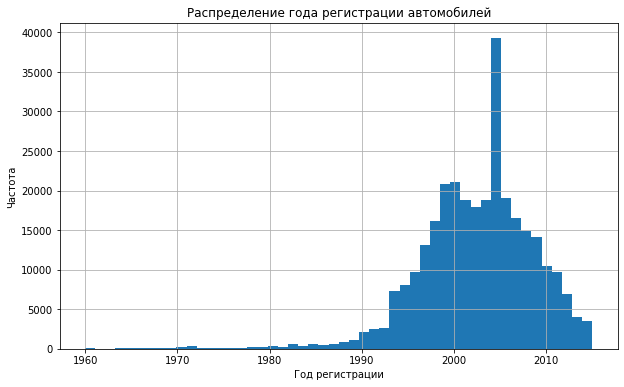

count    304695.000000
mean       2002.450132
std           6.195147
min        1960.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2015.000000
Name: RegistrationYear, dtype: float64

In [28]:
# Удалим строки с некорректными значениями в столбце 'RegistrationYear'
data = data.query('1960 <= RegistrationYear <= 2015')

# Выведем итоговую диаграмму распределения года регистрации автомобилей
df=data
col='RegistrationYear'
title='Распределение года регистрации автомобилей'
label='Год регистрации'
bins=50
hist_num(df, col, title, label, bins)

Остальные количественные признаки

array([[<AxesSubplot:title={'center':'Kilometer'}>,
        <AxesSubplot:title={'center':'RegistrationMonth'}>],
       [<AxesSubplot:title={'center':'PostalCode'}>, <AxesSubplot:>]],
      dtype=object)

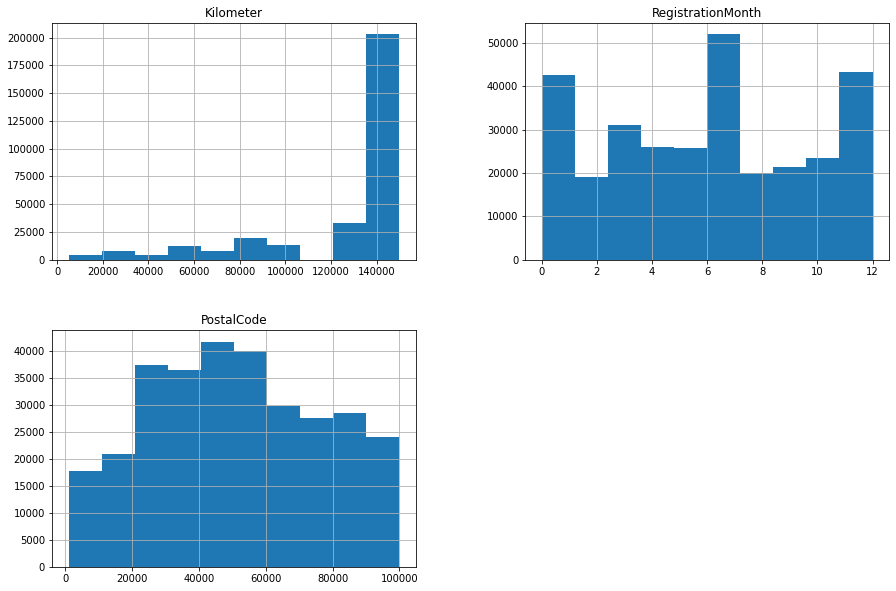

In [29]:
# Посмотрим на распределения остальных числовых признаков в датасете
data[['Kilometer', 'RegistrationMonth', 'PostalCode']].hist(figsize=(15, 10))

Пропусков они не имеют, распределения не вызывают вопросов.
Продолжим предобработку данных, на очереди категориальные признаки.

In [30]:
# Проверим данные на наличие опечаток
print(data['VehicleType'].unique())
print(data['Gearbox'].unique())
print(data['FuelType'].unique())

[nan 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'coupe' 'other']
['manual' 'auto' nan]
['petrol' 'gasoline' nan 'lpg' 'other' 'hybrid' 'cng' 'electric']


Данные по типам кузова, КПП и топлива в порядке, опечаток или дублирований не обнаружено. Обращает на себя внимание наличие в данных одновременно Nan и 'other' во всех трех столбцах, разберемся с этим в индивидуальном порядке.

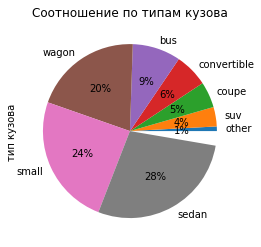

In [31]:
# Выведем диаграмму соотношения по типам кузова
df=data
col='VehicleType'
title='Соотношение по типам кузова'
label='тип кузова'
pie_cat(df, col, title, label)

In [32]:
# Заполним пропуски в 'VehicleType' модальным значением для соответсвующих 'Brand' и 'Model'
data['VehicleType'] = data['VehicleType'].fillna( \
                                                 data.groupby(['Brand', 'Model'])['VehicleType'] \
                                                 .transform(lambda x: x.value_counts().idxmax()))

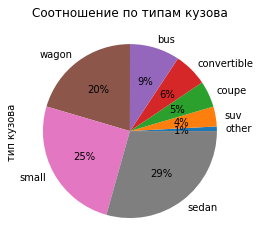

In [33]:
# Выведем диаграмму соотношения по типам кузова после заполнения пропусков
df=data
col='VehicleType'
title='Соотношение по типам кузова'
label='тип кузова'
pie_cat(df, col, title, label)

Пропуски заполнились корректно, количество other незначительное, оставляем other. Далее тип КПП.

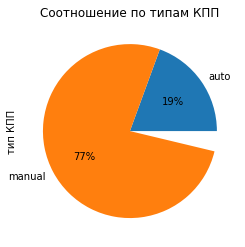

In [34]:
# Выведем диаграмму соотношения по типам КПП
df=data
col='Gearbox'
title='Соотношение по типам КПП'
label='тип КПП'
pie_cat(df, col, title, label)

In [35]:
# Заполним пропуски в 'Gearbox' модальным значением для соответсвующих 'Brand' и 'Model'
data['Gearbox'] = data['Gearbox'].fillna( \
                                         data.groupby(['Brand', 'Model'])['Gearbox'] \
                                         .transform(lambda x: x.value_counts().idxmax()))

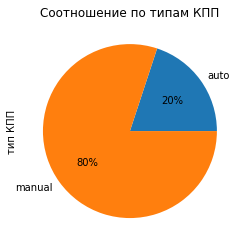

In [36]:
# Выведем диаграмму соотношения по типам КПП после заполнения пропусков
df=data
col='Gearbox'
title='Соотношение по типам КПП'
label='тип КПП'
pie_cat(df, col, title, label)

Судя по диаграмме пропуски заполинлись корректно. Далее на очереди тип используемого топлива.

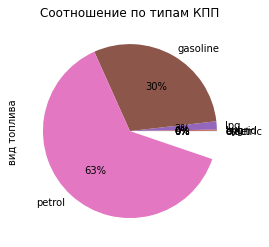

In [37]:
# Выведем диаграмму соотношения по видам топлива
df=data
col='FuelType'
title='Соотношение по типам КПП'
label='вид топлива'
pie_cat(df, col, title, label)

In [38]:
# Заполним пропуски в 'FuelType' модальным значением для соответсвующих 'Brand' и 'Model'
data['FuelType'] = data['FuelType'].fillna( \
                                                 data.groupby(['Brand', 'Model'])['FuelType'] \
                                                 .transform(lambda x: x.value_counts().idxmax()))

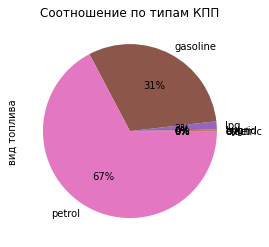

In [39]:
# Выведем диаграмму соотношения по видам топлива после заполнения пропусков
df=data
col='FuelType'
title='Соотношение по типам КПП'
label='вид топлива'
pie_cat(df, col, title, label)

Тоже все хорошо. Далее признак Repaired — была машина в ремонте или нет.

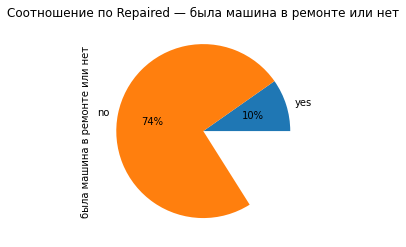

In [40]:
# Выведем диаграмму соотношения по Repaired — была машина в ремонте или нет
df=data
col='Repaired'
title='Соотношение по Repaired — была машина в ремонте или нет'
label='была машина в ремонте или нет'
pie_cat(df, col, title, label)


10% машин были в ремонте, 73% - нет, 17% - пропуски. Большенство автомобилей регулярно подвергаются хотя бы мелким ремонтам, даже новые (к примеру по гарантии). И судя по распределению, в данном случае имеется ввиду какой-то серьезный ремонт, вероятно после ДТП или иного события потребовавшего серьезного восстановления автомобиля и (или) лакокрасочного покрытия. Таким образом, оставшиеся 17% вероятно также не подвергались таким ремонтам, иначе бы об этом было явно указано. 
<br>
Заменим пропуски на 'no'.

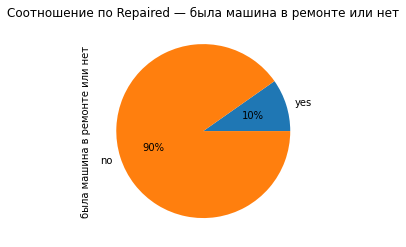

In [41]:
# Заменим пропуски на 'no'
data['Repaired'] = data['Repaired'].fillna('no')

# Выведем итоговую диаграмму соотношения по Repaired — была машина в ремонте или нет
df=data
col='Repaired'
title='Соотношение по Repaired — была машина в ремонте или нет'
label='была машина в ремонте или нет'
pie_cat(df, col, title, label)

In [42]:
# Оценим итоговое количество пропусков в данных
data.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

In [43]:
# В заключение удалим явные дубликаты
data = data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304690 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   DateCrawled        304690 non-null  object 
 1   Price              304690 non-null  int64  
 2   VehicleType        304690 non-null  object 
 3   RegistrationYear   304690 non-null  int64  
 4   Gearbox            304690 non-null  object 
 5   Power              304690 non-null  float64
 6   Model              304690 non-null  object 
 7   Kilometer          304690 non-null  int64  
 8   RegistrationMonth  304690 non-null  int64  
 9   FuelType           304690 non-null  object 
 10  Brand              304690 non-null  object 
 11  Repaired           304690 non-null  object 
 12  DateCreated        304690 non-null  object 
 13  NumberOfPictures   304690 non-null  int64  
 14  PostalCode         304690 non-null  int64  
 15  LastSeen           304690 non-null  object 
dtypes:

Пропуски, для которых существует методика корректного заполнения заполнены. Строки с пропусками, для которых нет корректной методики заполнения - удалены. Пропусков в данных больше нет. Дубликаты удалены. Данные подготовлены для дальнейшей работы.
<br>
<br>
Далее нам необходимо убрать лишние признаки. Так как мы готовим приложение в котором можно будет узнать рыночную стоимость своего автомобиля, нам необходимо оставить только те признаки, которые пользователь сможет подавать приложению на вход. Очевидно, что даты создания объявления, скачивания анкеты из базы или последнего активности пользователя не получится подать на вход в приложении, поэтому их удаляем. Месяц регистрации отражает скорее сезонность в активности рынка и не влияет на стоимость автомобиля, как год регистрации, поэтому тоже удаляем. Почтовый индекс отражает регион продажи, а он в свою очередь может влиять на стоимость, однако владельцы с одной улицы могут иметь разные индексы поэтому нужно их как-то объединять в более крупные сегменты для анализа, а такой возможности нет, удаляем.

In [44]:
# Удалим лишние признаки из датасета
data = data.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)

Выведем матрицу корреляции между признаками.

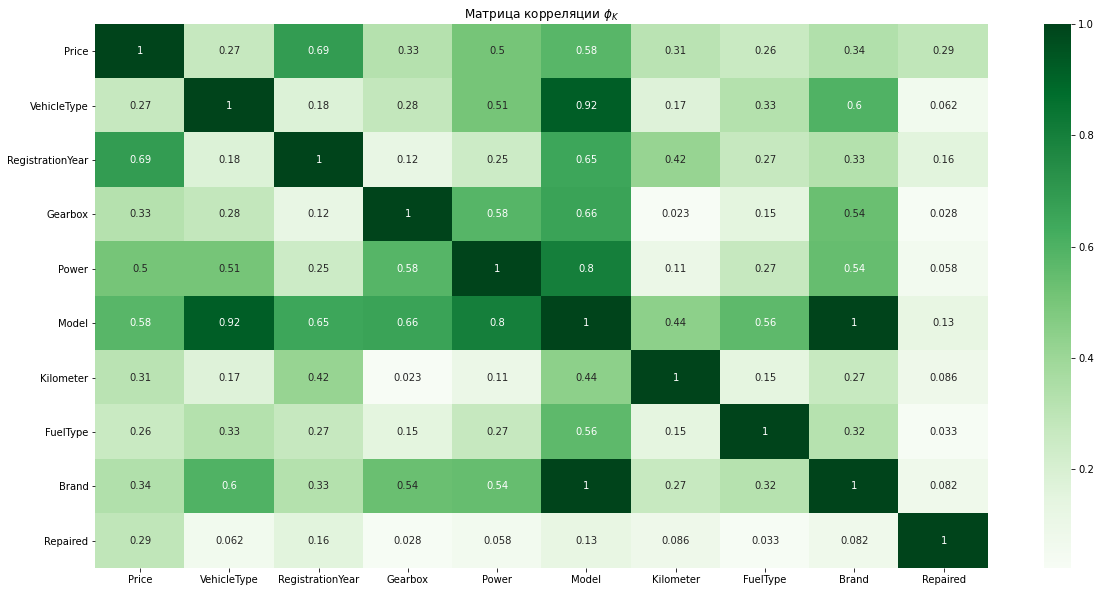

In [45]:
# Обозначим количественные признаки для матрицы
interval_cols = ['Price', 'RegistrationYear', 'Power', 'Kilometer']

# Выведем матрицу корреляции
target_matrix = data.phik_matrix(interval_cols = interval_cols)
plt.figure(figsize=(20, 10))
sns.heatmap(target_matrix, annot=True, cmap='Greens')
plt.title('Матрица корреляции $\phi_K$')
plt.show()

In [46]:
# Выделим и отсортируем коэффициенты корреляции с нашим целевым признаком
target_matrix['Price'].sort_values(ascending=False)

Price               1.000000
RegistrationYear    0.687861
Model               0.578856
Power               0.504455
Brand               0.337219
Gearbox             0.325419
Kilometer           0.311738
Repaired            0.293521
VehicleType         0.271261
FuelType            0.260809
Name: Price, dtype: float64

Высокая корреляционная связь с целевым признаком у признаков 'RegistrationYear' 'Model' и 'Power', средняя у всех остальных признаков. Все в целом ожидаемо, без неожиданностей.

## Обучение моделей

### Подготовка выборок для обучения моделей.

In [47]:
# Выведем список признаков датасета
data.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'Repaired'],
      dtype='object')

Модели и бренды закодируем TargetEncoder так как они содержат много уникальных значений. Остальные категориальные признаки закодируем OneHotEncoder, в них уникальных значений минимум.

In [48]:
# Подготовим выборки для обучения моделей

# Разделим датасет на входные признаки и целевой
X = data.drop('Price', axis=1)
y = data['Price']

# Разделим данные на тренировочные и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Кодирование категориальных переменных

# TargetEncoder для Model и Brand
target_encoder = TargetEncoder(smoothing=0.5)

# Применим кодирование только к тренировочной выборке
train_encoded = target_encoder.fit_transform(X_train[['Model', 'Brand']], y_train)
X_train[['Model', 'Brand']] = train_encoded

# Применим то же кодирование к тестовой выборке
test_encoded = target_encoder.transform(X_test[['Model', 'Brand']])
X_test[['Model', 'Brand']] = test_encoded

# One-Hot Encoder для категориальных признаков
categorical_cols = ['VehicleType', 'Gearbox', 'FuelType', 'Repaired']
ohe = OneHotEncoder(sparse=False, drop='first', handle_unknown='ignore')

# Применим кодирование только к тренировочной выборке
ohe_cols_train = pd.DataFrame(ohe.fit_transform(X_train[categorical_cols]),
                             columns=ohe.get_feature_names_out(categorical_cols),
                             index=X_train.index)
X_train = X_train.drop(categorical_cols, axis=1)
X_train = pd.concat([X_train, ohe_cols_train], axis=1)

# Применим то же кодирование к тестовой выборке
ohe_cols_test = pd.DataFrame(ohe.transform(X_test[categorical_cols]),
                            columns=ohe.get_feature_names_out(categorical_cols),
                            index=X_test.index)
X_test = X_test.drop(categorical_cols, axis=1)
X_test = pd.concat([X_test, ohe_cols_test], axis=1)

# Стандартизируем числовые признаки
numerical_cols = ['RegistrationYear', 'Power', 'Kilometer', 'Model', 'Brand']
scaler = StandardScaler()

# Применим масштабирование только к тренировочной выборке
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])

# Применим то же масштабирование к тестовой выборке
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])


Создадим функцию для вывода результатов модели, чтобы в дальнейшем применять ее для сравнения моделей

In [49]:
# Создадим функцию для вывода результатов модели
def evaluate_model(model, params):
        
    # Grid Search для поиска лучших параметров
    grid = GridSearchCV(model, params, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
    grid.fit(X_train, y_train)
    
    # Получаем метрики из результатов GridSearch
    mean_fit_time = grid.cv_results_['mean_fit_time'].mean()
    mean_score_time = grid.cv_results_['mean_score_time'].mean()
    
    # Преобразуем оценку из отрицательной MSE в RMSE
    mean_rmse = (-grid.best_score_)**0.5
    
       
    return {
        'best_params': grid.best_params_,
        'rmse': mean_rmse,
        'mean_fit_time': mean_fit_time,
        'mean_score_time': mean_score_time,
        'best_estimator': grid.best_estimator_
    }


### Обучение моделей

Обучим четыре модели и выведем лучшие гиперпараметры, метрику RMSE и затраченной время на обучение для каждой модели.

In [50]:
# 1. Линейная регрессия
print("Линейная регрессия")
linear_pipeline = make_pipeline(
    StandardScaler(with_mean=False),
    LinearRegression()
)

linear_params = {}

linear_results = evaluate_model(linear_pipeline, linear_params)
print(f"Лучшие параметры: {linear_results['best_params']}")
print(f"RMSE: {linear_results['rmse']:.4f}")
print(f"Время обучения: {linear_results['mean_fit_time']:.2f} секунд")
print(f"Время предсказания: {linear_results['mean_score_time']:.2f} секунд\n")


# 2. Decision Tree
print("Decision Tree")
tree_params = {
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

tree_results = evaluate_model(DecisionTreeRegressor(), tree_params)
print(f"Лучшие параметры: {tree_results['best_params']}")
print(f"RMSE: {tree_results['rmse']:.4f}")
print(f"Время обучения: {tree_results['mean_fit_time']:.2f} секунд")
print(f"Время предсказания: {tree_results['mean_score_time']:.2f} секунд\n")


# 3. CatBoost
print("CatBoost")
catboost_params = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1]
}

catboost_results = evaluate_model(CatBoostRegressor(verbose=0), catboost_params)
print(f"Лучшие параметры: {catboost_results['best_params']}")
print(f"RMSE: {catboost_results['rmse']:.4f}")
print(f"Время обучения: {catboost_results['mean_fit_time']:.2f} секунд")
print(f"Время предсказания: {catboost_results['mean_score_time']:.2f} секунд\n")


# 4. LGBM
print("LGBM")
lgbm_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1]
}

lgbm_results = evaluate_model(LGBMRegressor(), lgbm_params)
print(f"Лучшие параметры: {lgbm_results['best_params']}")
print(f"RMSE: {lgbm_results['rmse']:.4f}")
print(f"Время обучения: {lgbm_results['mean_fit_time']:.2f} секунд")
print(f"Время предсказания: {lgbm_results['mean_score_time']:.2f} секунд\n")

Линейная регрессия
Лучшие параметры: {}
RMSE: 2713.8730
Время обучения: 0.53 секунд
Время предсказания: 0.06 секунд

Decision Tree
Лучшие параметры: {'max_depth': 9, 'min_samples_leaf': 4, 'min_samples_split': 10}
RMSE: 1950.6273
Время обучения: 0.38 секунд
Время предсказания: 0.01 секунд

CatBoost
Лучшие параметры: {'iterations': 300, 'learning_rate': 0.1}
RMSE: 1650.7270
Время обучения: 6.57 секунд
Время предсказания: 0.02 секунд

LGBM
Лучшие параметры: {'learning_rate': 0.1, 'n_estimators': 300}
RMSE: 1584.2439
Время обучения: 8.37 секунд
Время предсказания: 0.77 секунд



Обучены четыре модели, получены для каждой модели лучшие гиперпараметры по метрике RMSE.

## Анализ моделей

Для анализа моделей соберем результаты в таблицу.

In [51]:
# Сохранение результатов в словарь
results = {
    'LinearRegression': linear_results,
    'DecisionTree': tree_results,
    'CatBoost': catboost_results,
    'LGBM': lgbm_results
}

# Создаем DataFrame с результатами
results_df = pd.DataFrame({
    'Модель': list(results.keys()),
    'RMSE, евро': [results[model]['rmse'] for model in results],
    'Время обучения, сек': [results[model]['mean_fit_time'] for model in results],
    'Время предсказания, сек': [results[model]['mean_score_time'] for model in results],
    'Best Params': [results[model]['best_params'] for model in results]
}, index=None)

print("Результаты моделей:")

display(results_df.sort_values(by='RMSE, евро', ascending=True).reset_index(drop=True).style.format({
    'RMSE, евро': '{:.2f}',
    'Время обучения, сек': '{:.2f}'
}))


Результаты моделей:


,Модель,"RMSE, евро","Время обучения, сек","Время предсказания, сек",Best Params
0,LGBM,1584.24,8.37,0.766546,"{'learning_rate': 0.1, 'n_estimators': 300}"
1,CatBoost,1650.73,6.57,0.016938,"{'iterations': 300, 'learning_rate': 0.1}"
2,DecisionTree,1950.63,0.38,0.006857,"{'max_depth': 9, 'min_samples_leaf': 4, 'min_samples_split': 10}"
3,LinearRegression,2713.87,0.53,0.060064,{}


In [52]:
# Выведем лучшую модель по RMSE
best_rmse_model = results_df.loc[results_df['RMSE, евро'].idxmin()]

# Выводим информацию о лучшей модели по RMSE
print("\nЛучшая модель по RMSE:")
print(f"Модель: {best_rmse_model['Модель']}")
print(f"RMSE: {best_rmse_model['RMSE, евро']:.2f}")
print(f"Время обучения: {best_rmse_model['Время обучения, сек']:.2f} секунд")
print(f"Время предсказания: {best_rmse_model['Время предсказания, сек']:.2f} секунд")
print(f"Параметры модели: {best_rmse_model['Best Params']}")


Лучшая модель по RMSE:
Модель: LGBM
RMSE: 1584.24
Время обучения: 8.37 секунд
Время предсказания: 0.77 секунд
Параметры модели: {'learning_rate': 0.1, 'n_estimators': 300}


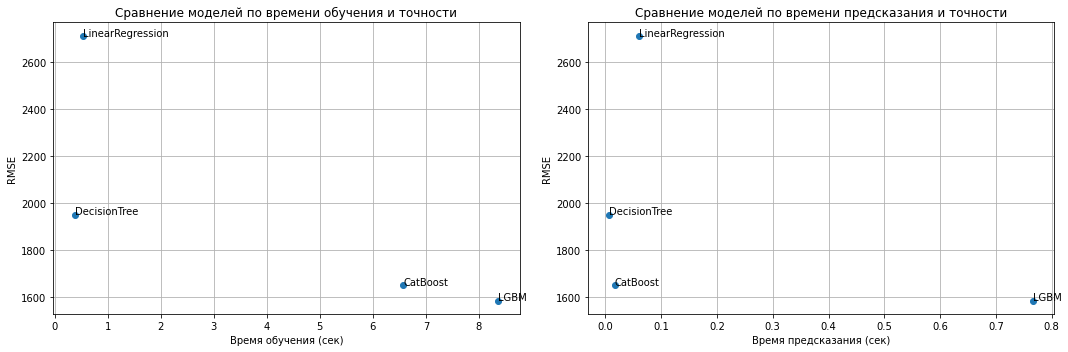

In [53]:
# Визуализация результатов
plt.figure(figsize=(15, 5))

# График время обучения vs RMSE
plt.subplot(1, 2, 1)
plt.scatter(results_df['Время обучения, сек'], results_df['RMSE, евро'])
plt.xlabel('Время обучения (сек)')
plt.ylabel('RMSE')
plt.title('Сравнение моделей по времени обучения и точности')
plt.grid()
for i, txt in enumerate(results_df['Модель']):
    plt.annotate(txt, (results_df['Время обучения, сек'][i], results_df['RMSE, евро'][i]))

# График время предсказания vs RMSE
plt.subplot(1, 2, 2)
plt.scatter(results_df['Время предсказания, сек'], results_df['RMSE, евро'])
plt.xlabel('Время предсказания (сек)')
plt.ylabel('RMSE')
plt.title('Сравнение моделей по времени предсказания и точности')
plt.grid()
for i, txt in enumerate(results_df['Модель']):
    plt.annotate(txt, (results_df['Время предсказания, сек'][i], results_df['RMSE, евро'][i]))

plt.tight_layout()
plt.show()


По результатам анализа моделей найлучший результат по метрике RMSE показала модель LGBM, при этом она имеет самое продолжительное время обучения и предсказания. 
<br>
<br>
Критерии, которые важны заказчику:
<br>качество предсказания;
<br>время обучения модели;
<br>время предсказания модели.
<br>
<br>
Исходя из них оптимальной моделью является CatBoost, при схожем уровне RMSE и времени обучения, время предсказания на порядок меньше, а это важный для Заказчика критерий.
<br>
Проверим ее качество на тестовых данных.

In [54]:
# Загружаем лучшую модель
best_estimator = catboost_results['best_estimator']

# Делаем предсказания на тестовых данных
y_test_pred = best_estimator.predict(X_test)

# Оцениваем результаты
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
print(f"RMSE на тестовых данных: {test_rmse:.4f}")

RMSE на тестовых данных: 1647.4318


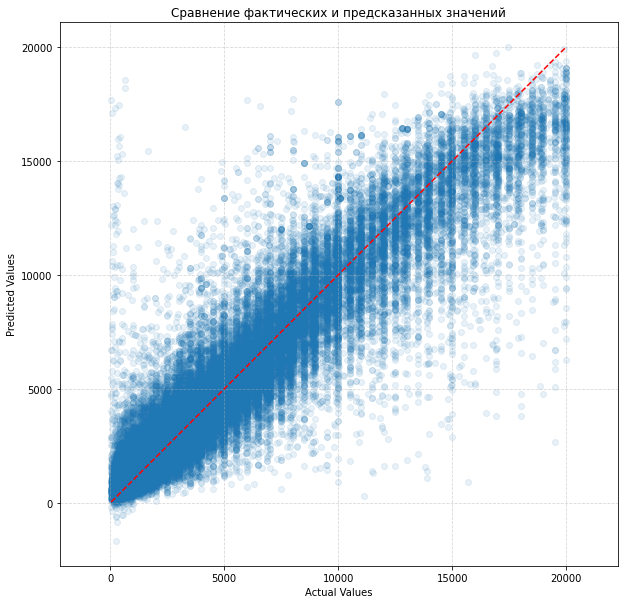

In [55]:
# Построим график сравнения фактических и предсказанных значений
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_test_pred, alpha=0.1)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.grid(True, linestyle='--', alpha=0.5)
plt.axis('equal')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Сравнение фактических и предсказанных значений')
plt.show()

Судя по графику, в интервале высоких цен на автомобили есть небольшое занижение стоимости со стороны модели относительно факта. В целом график подтверждает корректную работу модели Catboost.

## Выводы

Нам нужно построить модель для определения рыночной стоимости автомобилей для сервиса по продаже автомобилей с пробегом «Не бит, не крашен». В нашем распоряжении были исторические данные: технические характеристики и цены автомобилей. Заказчику важны качество предсказания и время обучения.
<br>
В процессе работы над проектом нами были корректно заполнены пропуски в данных, там где это было возможно. Там где такой возмоности не имелось строки были удалены. Удалены дубликаты и лишние (бесполезные для моделей) признаки.
<br>
Процессе работы были обучениы четыре модели машинного обучения: Линейная регрессия, DecissionTree регрессия, CatBoostRegressor и Регрессия LGBM. При обучении моделей осуществялся перебор нескольких гиперпараметров для каждой модели. По метрике RMSE отобраны лучшие гиперпараметры для каждой модели.
<br>
Затем произведено сравние результатов моделей по метрике RMSE и времени затраченному на обучение и предсказания. 
<br>
По результатам анализа моделей найлучший результат по метрике RMSE показала модель LGBM, при этом она имеет самое продолжительное время обучения и предсказания.
Исходя критериев, которые важны Заказчику (качество предсказания, время обучения и предсказания модели), оптимальной моделью является CatBoost, при схожем уровне RMSE ее время обучения и предсказания на порядок меньше.
<br>
После выбора модели CatBoost в качестве оптимальной, проверили ее качество на тестовых данных. Метрика RMSE осталась на том же уровне.
<br>
Данная модель рекомендуются к применению в качестве оптимальной для решения поставленной в проекте задачи.
